# Black-Scholes and the Greeks. 

A Python friendly intro to options. We'll have a look at creating some option payoff functions, an implementation of Black-Scholes pricing and then finish up with some sensitivity analysis (Greeks). I'll provide a fairly high level overview of what we're doing, but some basic knowledge in options is always good (Google is your friend). I'm by no means an expert in options, but find that implementing them in Python is good practice in some fundamental skills like list manipulations, maps, plotting and taking it one step further into object-oriented programming.

\begin{equation*}
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2S^2\frac{\partial V^2}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0
\end{equation*}

Perhaps the most famous and possibly infamous equation in quantitative finance is the Black-Scholes equation. A PDE which provides the time evolving price of a vanilla option, specifically European put and call options. 

The equation can be solved, to yield a fairly simple closed-form solution for an option price for a non-dividend underlying (and a whole bunch of other assumptions such as efficient markets, no transaction costs etc.). 

\begin{equation*}
C(S_t, t) = N(d_1)S_t - N(d_2)Ke^{-r(T-t)}
\end{equation*}

With 
\begin{array}{c}
d_1 = \frac{1}{\sigma\sqrt{T-t}}\Bigl[ln\Bigl(\frac{S_t}{k}\Bigr) + \Bigl(r + \frac{\sigma^2}{2}\Bigr)(T-t)\Bigr] \\\
d_2 = d_1 - \sigma\sqrt{T-t}
\end{array}

The above equation can be interpreted as the call option premium is the difference between the expected benefit of purchasing the underlying outright at time t against the present value of purchasing the underlying at the strike price at expiration time T. Another way to interpret the call option premium/option value is through intrinsic value and time value, where the option value is comprised of:
1. Intrinsic value of exercising the option immediately i.e. what would the payoff be if we exercised
2. The time value of the option derived from the random behaviour of the underlying. As the underlying stock is typically modelled as a stochastic process, there is a probabilistic component which basically means there is some chance that the stock price could move significantly in our favour over time. Thus, we would typically expect to pay higher premiums for options with longer maturities.

Check out [here](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model) for a basic introduction and links to all the relevant source material.

The above formulae, as well as some derivatives provide all we'll need to explore the Black Scholes framework for vanilla puts/calls as well as their sensitivies to underyling paramters (the Greeks).

## Implementation of Formula

### Payoff Functions

Payoff functions are key to understanding the profit (and loss) that we'll receive upon purchasing an option or options. They are typically designed so that you can view the strike price on the purchased (or sold) option, as a function of the underlyings price. 

For now we'll only plot some basic options and option strategies, without doing any calculations of the option prices. The option price will simply be a parameter which we feed into the payoff functions. Later, we'll return and price a European option using the above Black-Scholes method, and this will allow us to build out some more complex option strategy payoff functions with varying maturities.

Basic Concepts/Definitions:
* ITM (In-the-money): An option is ITM if it is currently "worth" exercising today i.e. for a call option the current underlying's price is greater than the strike price (and vice versa for a put).
* OTM (Out-of-the-money): An option is OTM if it is currently "not worth" exercising today.
* ATM (At-the-money): An option is ATM if it is neither ITM or OTM, i.e. exercising today would have no tangible effect (ignoring any transaction costs/option premiums).
* Strike Price: This is the price at which our option is exercised at
* Underlying: This refers to the asset (which could really be anything which has a price) which underlies the derivative contract.


In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

#### make a funcion that lets you specify a few parameters and calculates the payoff

# S = stock underlying
# K = strike price
# Price = premium paid for option
def long_call(S, K, Price):
    # Long Call Payoff = max(Stock Price - Strike Price, 0)
    # If we are long a call, we would only elect to call if the current stock price is greater than 
    # the strike price on our option
    
    P = list(map(lambda x: max(x - K, 0) - Price, S))
    return P

def long_put(S, K, Price):
    # Long Put Payoff = max(Strike Price - Stock Price, 0)
    # If we are long a call, we would only elect to call if the current stock price is less than 
    # the strike price on our option
    
    P = list(map(lambda x: max(K - x,0) - Price, S))
    return P
   
def short_call(S, K, Price):
    # Payoff a shortcall is just the inverse of the payoff of a long call
    
    P = long_call(S, K, Price)
    return [-1.0*p for p in P]

def short_put(S,K, Price):
    # Payoff a short put is just the inverse of the payoff of a long put

    P = long_put(S,K, Price)
    return [-1.0*p for p in P]
    
def binary_call(S, K, Price):
    # Payoff of a binary call is either:
    # 1. Strike if current price > strike
    # 2. 0
    
    P = list(map(lambda x:  K - Price if x > K else 0 - Price, S))
    return P

def binary_put(S,K, Price):
    # Payoff of a binary call is either:
    # 1. Strike if current price < strike
    # 2. 0
    
    P = list(map(lambda x:  K - Price if x < K else 0 - Price, S))
    return P   

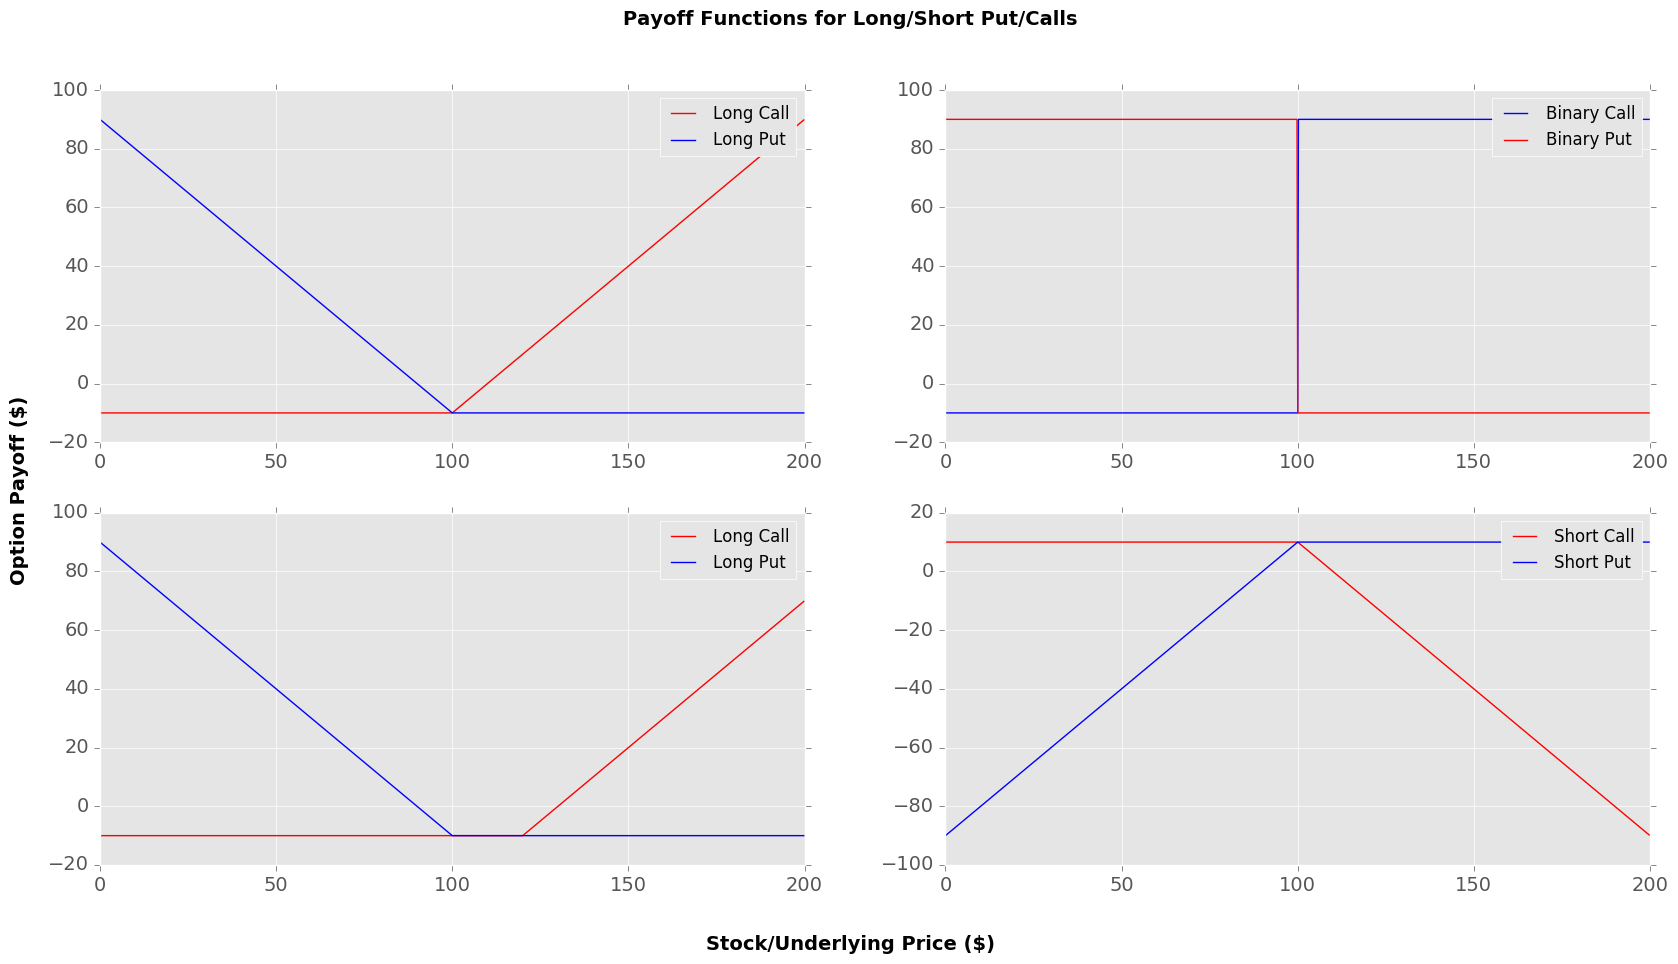

In [87]:
S = [t/5 for t in range(0,1000)] # Define some series of stock-prices                 

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(20, 10))
fig.suptitle('Payoff Functions for Long/Short Put/Calls', fontsize=14, fontweight='bold')
fig.text(0.5, 0.04, 'Stock/Underlying Price ($)', ha='center', fontsize=14, fontweight='bold')
fig.text(0.08, 0.5, 'Option Payoff ($)', va='center', rotation='vertical', fontsize=14, fontweight='bold')


lc_P = long_call(S,100, 10)
lp_P = long_put(S,100, 10)
plt.subplot(221)
plt.plot(S, lc_P, 'r')
plt.plot(S, lp_P, 'b')
plt.legend(["Long Call", "Long Put"])


bc_P = binary_call(S,100, 10)
bp_P = binary_put(S,100, 10)
plt.subplot(222)
plt.plot(S, bc_P, 'b')
plt.plot(S, bp_P, 'r')
plt.legend(["Binary Call", "Binary Put"])

T2 = long_call(S, 120, 10)
T4 = long_put(S,100, 10)
plt.subplot(223)
plt.plot(S,T2, 'r')
plt.plot(S, T4, 'b')
plt.legend(["Long Call", "Long Put"])


sc_P = short_call(S,100, 10)
sp_P = short_put(S,100, 10)
plt.subplot(224)
plt.plot(S, sc_P, 'r')
plt.plot(S, sp_P, 'b')
plt.legend(["Short Call", "Short Put"])

plt.show()
    

In addition to the standard long/short put/call options, it is possible to create a myriad of different options through combinations of these basic pieces. We'll only focus on creating different option structures that utilise different strike prices, there's a whole other world of options which also utilise different expirations (i.e. calendar spreads).

In [269]:
def bull_spread(S, E1, E2, Price1, Price2):
    
    P_1 = long_call(S, E1, Price1)
    P_2 = short_call(S, E2, Price2)
    return [x+y for x,y in zip(P_1, P_2)] 
     
def bear_spread(S, E1, E2, Price1, Price2):
    
    P = bull_spread(S,E1, E2, Price1, Price2)
    return [-1.0*p + 1.0 for p in P] 

def straddle(S, E, Price1, Price2):
    
    P_1 = long_call(S, E, Price1)
    P_2 = long_put(S, E, Price2)
    return [x+y for x,y in zip(P_1, P_2)]
    
def risk_reversal(S, E1, E2, Price1, Price2):
    
    P_1 = long_call(S, E1, Price1)
    P_2 = short_put(S,E2, Price2)
    return [x + y for x, y in zip(P_1, P_2)]

def strangle(S, E1, E2, Price1, Price2):
    
    P_1 = long_call(S, E1, Price1)
    P_2 = long_put(S, E2, Price2)
    return [x + y for x, y in zip(P_1, P_2)]


def butterfly_spread(S, E1, E2, E3, Price1, Price2, Price3):
    
    P_1 = long_call(S, E1, Price1)
    P_2 = long_call(S, E3, Price3)
    P_3 = short_call(S, E2, Price2)
    P_3 =[2*p for p in P_3]
    return [x + y + z for x, y, z in zip(P_1, P_2, P_3)]
    
def strip(S, E1, Price1, Price2):
    
    P_1 = long_call(S, E1, Price1)
    P_2 = long_put(S, E1, Price2)
    P_2 = [2*p for p in P_2]
    return [x+y for x,y in zip(P_1, P_2)]


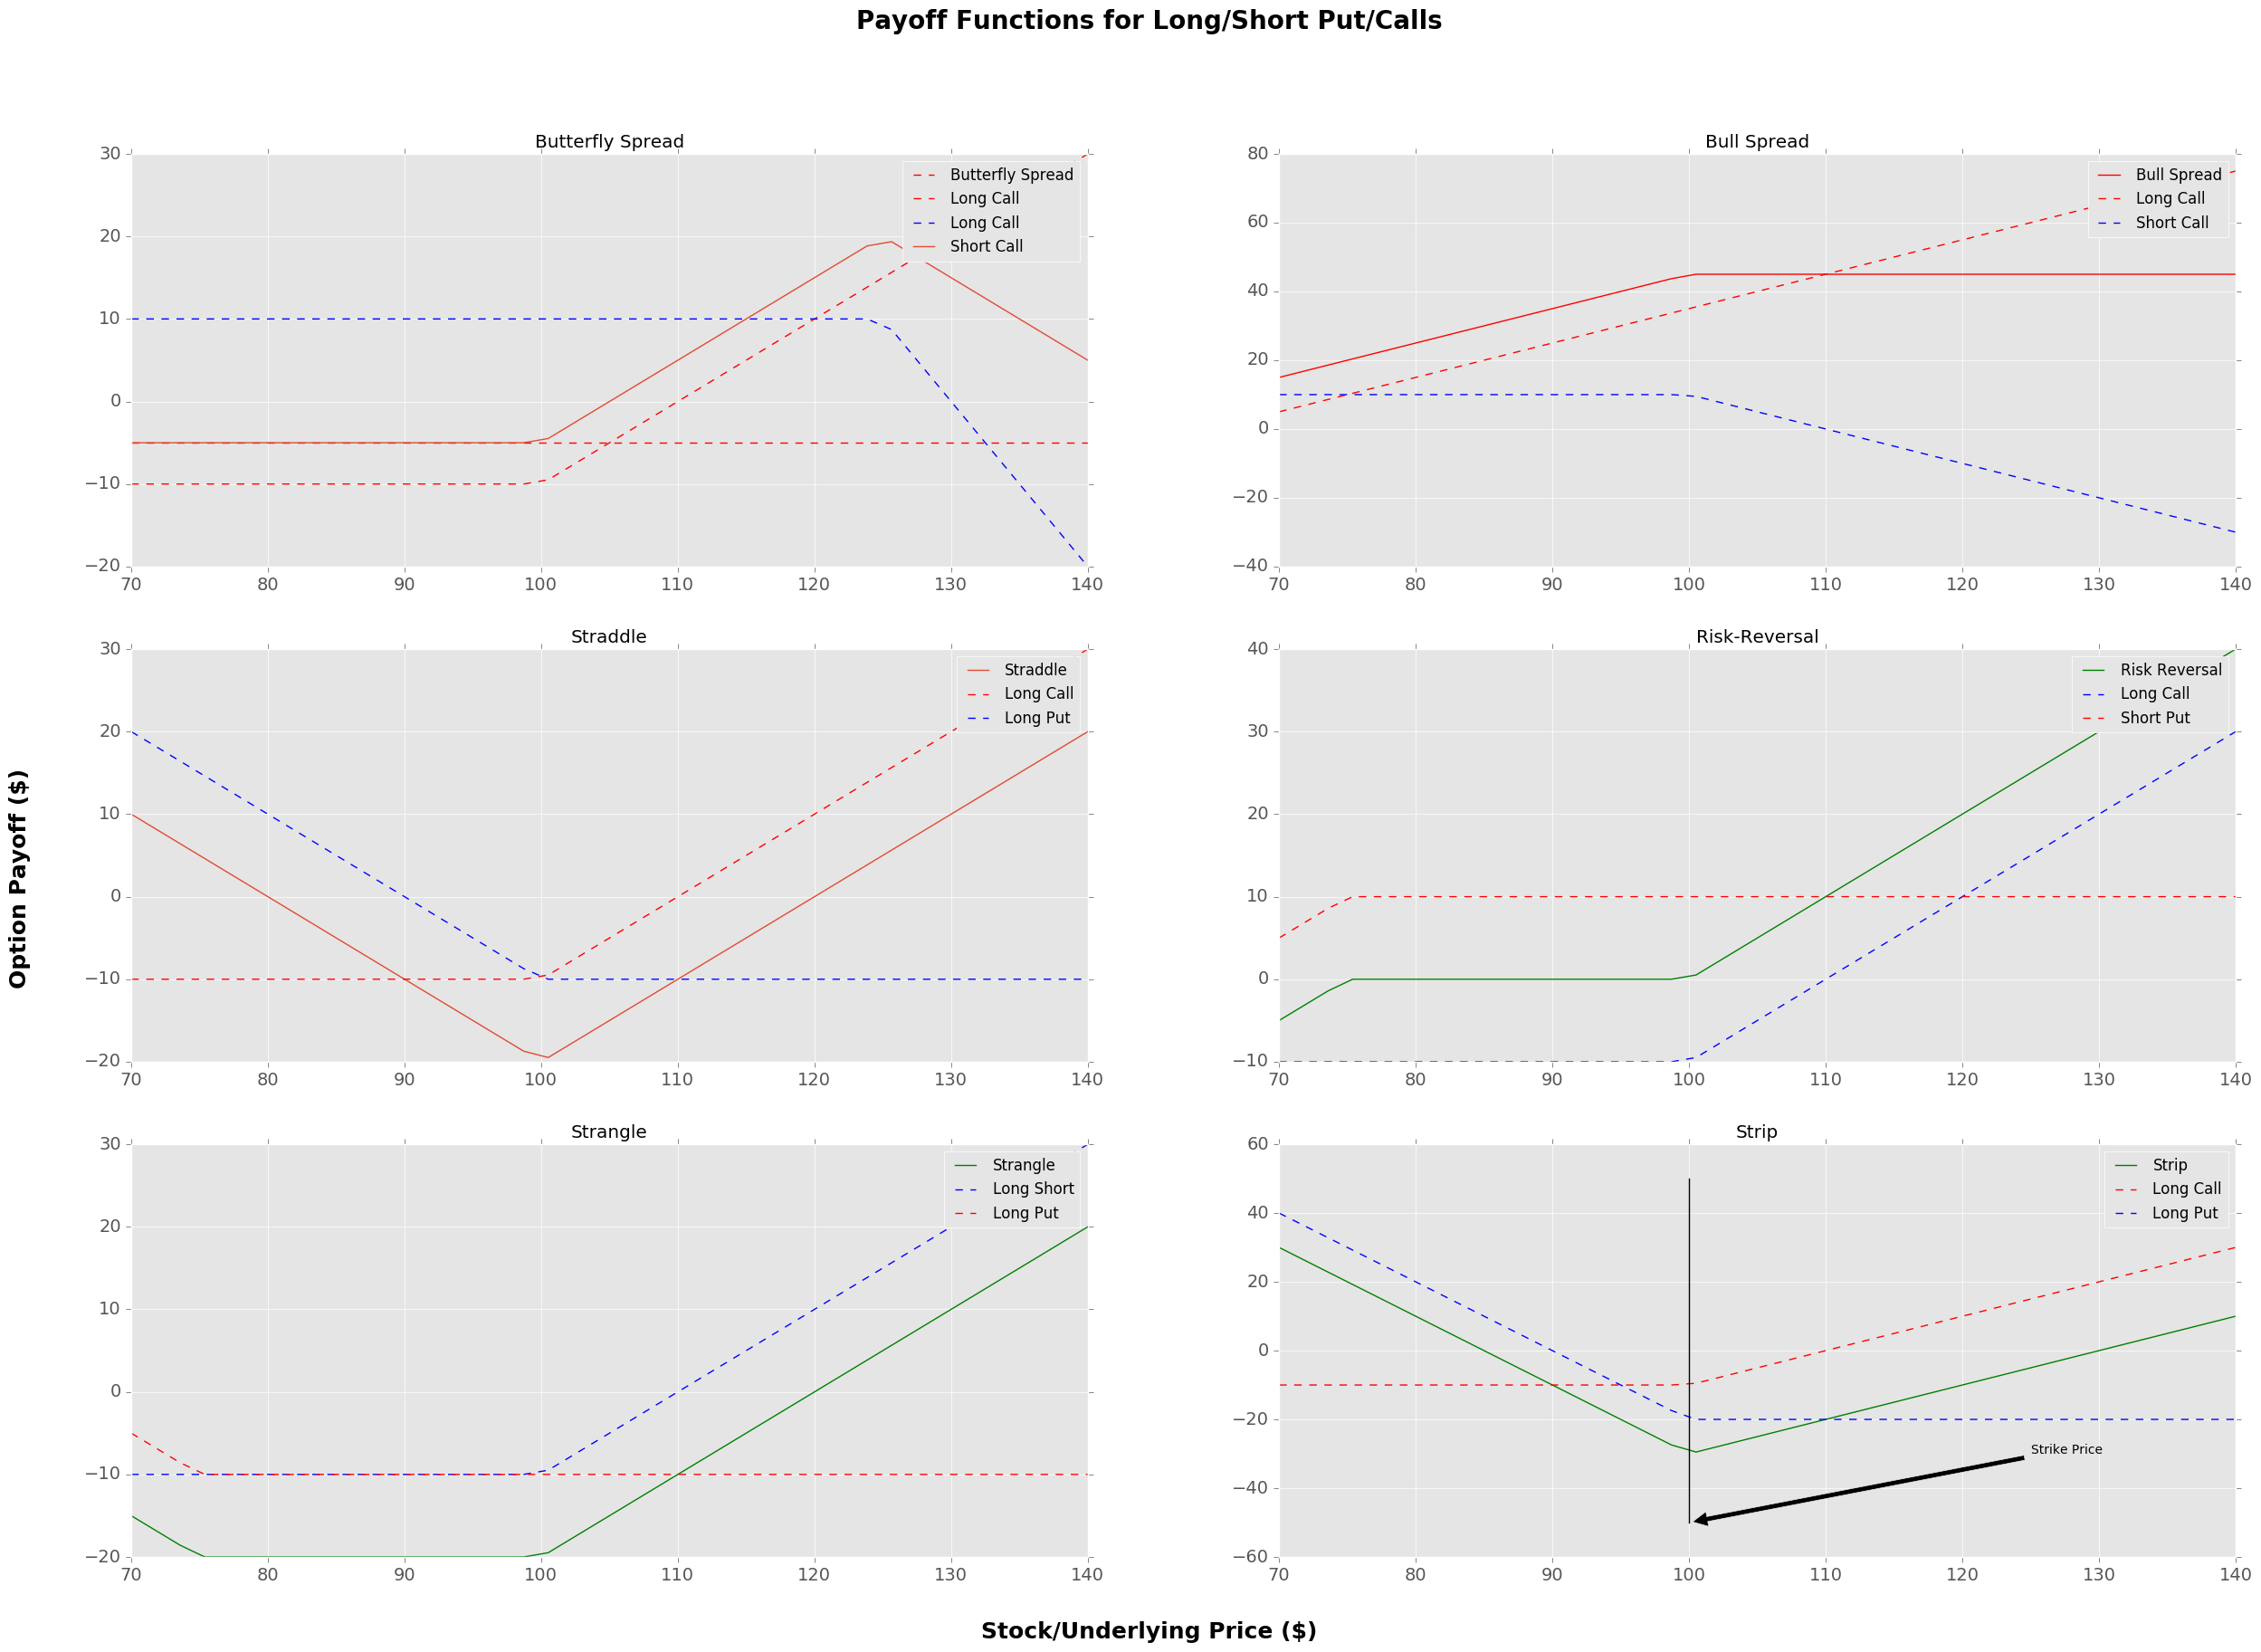

In [270]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(30, 20))
fig.suptitle('Payoff Functions for Long/Short Put/Calls', fontsize=20, fontweight='bold')
fig.text(0.5, 0.08, 'Stock/Underlying Price ($)', ha='center', fontsize=18, fontweight='bold')
fig.text(0.08, 0.5, 'Option Payoff ($)', va='center', rotation='vertical', fontsize=18, fontweight='bold')

plt.subplot(321)
P = butterfly_spread(S, 100, 125, 150, 10, 5, 5)
P_1 = long_call(S, 100, 10)
P_2 = long_call(S, 150, 5)
P_3 = short_call(S, 125, 5)
P_3 =[2*p for p in P_3]
plt.plot(S, P_1, 'r--')
plt.plot(S, P_2, 'r--')
plt.plot(S, P_3, 'b--')
plt.plot(S, P)
plt.legend(["Butterfly Spread", "Long Call", "Long Call", "Short Call"])
plt.title("Butterfly Spread")

plt.subplot(322)
P1 = bull_spread(S,50, 100, 15, 10)
long_c = long_call(S, 50, 15)
short_c = short_call(S, 100, 10)
    
plt.plot(S, P1, 'r')
plt.plot(S, long_c, 'r--')
plt.plot(S, short_c, 'b--')

plt.legend(["Bull Spread", "Long Call", "Short Call"])
plt.title("Bull Spread")

plt.subplot(323)
P = straddle(S,100, 10, 10)
P_longcall = long_call(S, 100, 10)
P_longput = long_put(S, 100, 10)
plt.plot(S, P) 
plt.plot(S, P_longcall, 'r--')
plt.plot(S, P_longput, 'b--')
plt.legend(["Straddle", "Long Call", "Long Put"])
plt.title("Straddle")

plt.subplot(324)
P = risk_reversal(S,100,75, 10, 10)
P_longcall = long_call(S, 100, 10)
P_shortput = short_put(S,75, 10)
plt.plot(S, P, 'g')
plt.plot(S, P_longcall, 'b--')
plt.plot(S, P_shortput, 'r--')
plt.legend(["Risk Reversal", "Long Call", "Short Put"])
plt.title("Risk-Reversal")

plt.subplot(325)
P = strangle(S,100, 75, 10, 10)
P_longcall = long_call(S, 100, 10)
P_longput = long_put(S, 75, 10)
plt.plot(S, P, 'g')
plt.plot(S, P_longcall, 'b--')
plt.plot(S, P_longput, 'r--')
plt.legend(["Strangle", "Long Short", "Long Put"])
plt.title("Strangle")

plt.subplot(326)
P_1 = long_call(S, 100, 10)
P_2 = long_put(S, 100, 10)
P_2 = [2*p for p in P_2]
P = strip(S, 100, 10, 10 )
plt.plot(S, P, 'g')
plt.plot(S, P_1, 'r--')
plt.plot(S, P_2, 'b--')
plt.plot([100,100],[-50,50],'black')
plt.legend(["Strip", "Long Call", "Long Put"])
plt.annotate('Strike Price', 
            xy=(100, -50), 
            xytext=(125, -30), 
            arrowprops = dict(facecolor='black', shrink=0.01))
plt.title("Strip")

plt.show()

### Implementing Black-Scholes
We can implement the equations we defined previously, to help us calculate the premium of an option, as well as the sensitivities of these equations to the various parameters. These sensitivities are known as "Greeks", and are obtained by taking various derivatives of the Black-Scholes equation w.r.t the underlying parameters.

In [138]:
from scipy.stats import norm

# S: underlying stock price
# K: Option strike price
# r: risk free rate
# D: dividend value
# vol: Volatility
# T: time to expiry (assumed that we're measuring from t=0 to T)

def d1_calc(S, K, r, vol, T, t):
    # Calculates d1 in the BSM equation
    return (np.log(S/K) + (r + 0.5 * vol**2)*(T-t))/(vol*np.sqrt(T-t))

def BS_call(S, K, r, vol, T, t):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)

def BS_put(S, K, r, vol, T, t):
    return BS_call(S, K, r, vol, T, t) - S + np.exp(-r*(T-t))*K

def BS_binary_call(S, K, r, vol, T, t):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T-t)
    return np.exp(-r*T)*norm.cdf(d2)

def BS_binary_put(S, K, r, vol, T, t):
    return BS_binary_call(S, K, r, vol, T,t) - S + np.exp(-r*(T-t))*K

###########################################################################
#1st Order Greeks
def delta(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T-t)
    
    if(otype == "call"):
        delta = np.exp(-(T-t))*norm.cdf(d1)
    elif(otype == "put"):
        delta = -np.exp(-(T-t))*norm.cdf(-d1)

    return delta

# Gamma for calls/puts the same

def vega(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    return S * norm.pdf(d1) * np.sqrt(T-t)

def rho(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol*np.sqrt(T-t)
    
    if(otype == "call"):
        rho = K*(T-t)*np.exp(-r*(T-t))*norm.cdf(d2)
    elif(otype == "put"):
        rho = -K*(T-t)*np.exp(-r*(T-t))*norm.cdf(-d2)
    return rho

def theta(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol*np.sqrt(T-t)
    
    if(otype == "call"):
        theta = -(S*norm.pdf(d1)*vol / (2*np.sqrt(T-t))) - r*K*np.exp(-r*(T-t))*norm.cdf(d2) 
    elif(otype == "put"):
        theta = -(S*norm.pdf(d1)*vol / (2*np.sqrt(T-t))) + r*K*np.exp(-r*(T-t))*norm.cdf(-d2)

    return theta

#2nd Order Greeks
def gamma(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    gamma = (norm.pdf(d1)) / (S * vol * np.sqrt(T-t))
    
    return gamma

def charm(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol*np.sqrt(T-t)
    charm = -norm.pdf(d1)*(2*r*(T-t) - d2*vol*np.sqrt(T-t))/(2*(T-t)*vol*np.sqrt(T-t))

    return charm

## Plotting Option Prices

The first place we'll start is by looking at how the value of an option changes with stock price. Let's assume that our strike is \$50, then a put will have it's highest value to us when the stock is worth \$0 as we could buy stock at \$0 and then exercise our put option to sell for \$50. A call is the opposite, our option to buy is worth the least if the stock price is \$0 and will increase in value as the stock price increases.

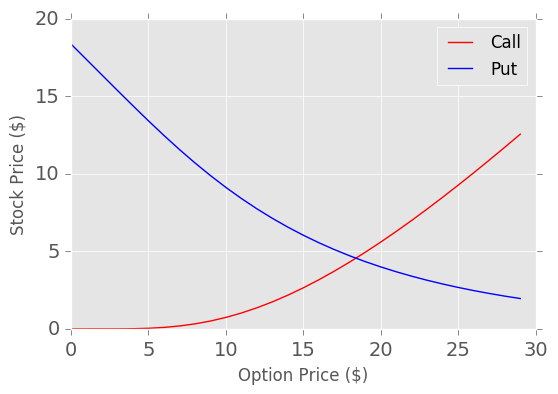

In [141]:
S = np.arange(0, 30)
vals_call = [BS_call(x, 50, 0.10, 0.2, 10, 0) for x in S]
vals_put = [BS_put(x, 50, 0.10, 0.2, 10, 0) for x in S]
plt.plot(S,vals_call, 'r', label = "Call")
plt.plot(S, vals_put, 'b', label  = "Put")
plt.legend()
plt.ylabel("Stock Price ($)")
plt.xlabel("Option Price ($)")
plt.show()

## Plotting Greeks

We can now look at the sensitivity of option greeks to a single parameter. I won't go into any detailed explanations on the greeks here, at a high level they're typically used as a risk measure on a portfolio of options. One would seek to manage their portfolio greeks within given risk appetites i.e. delta hedging.

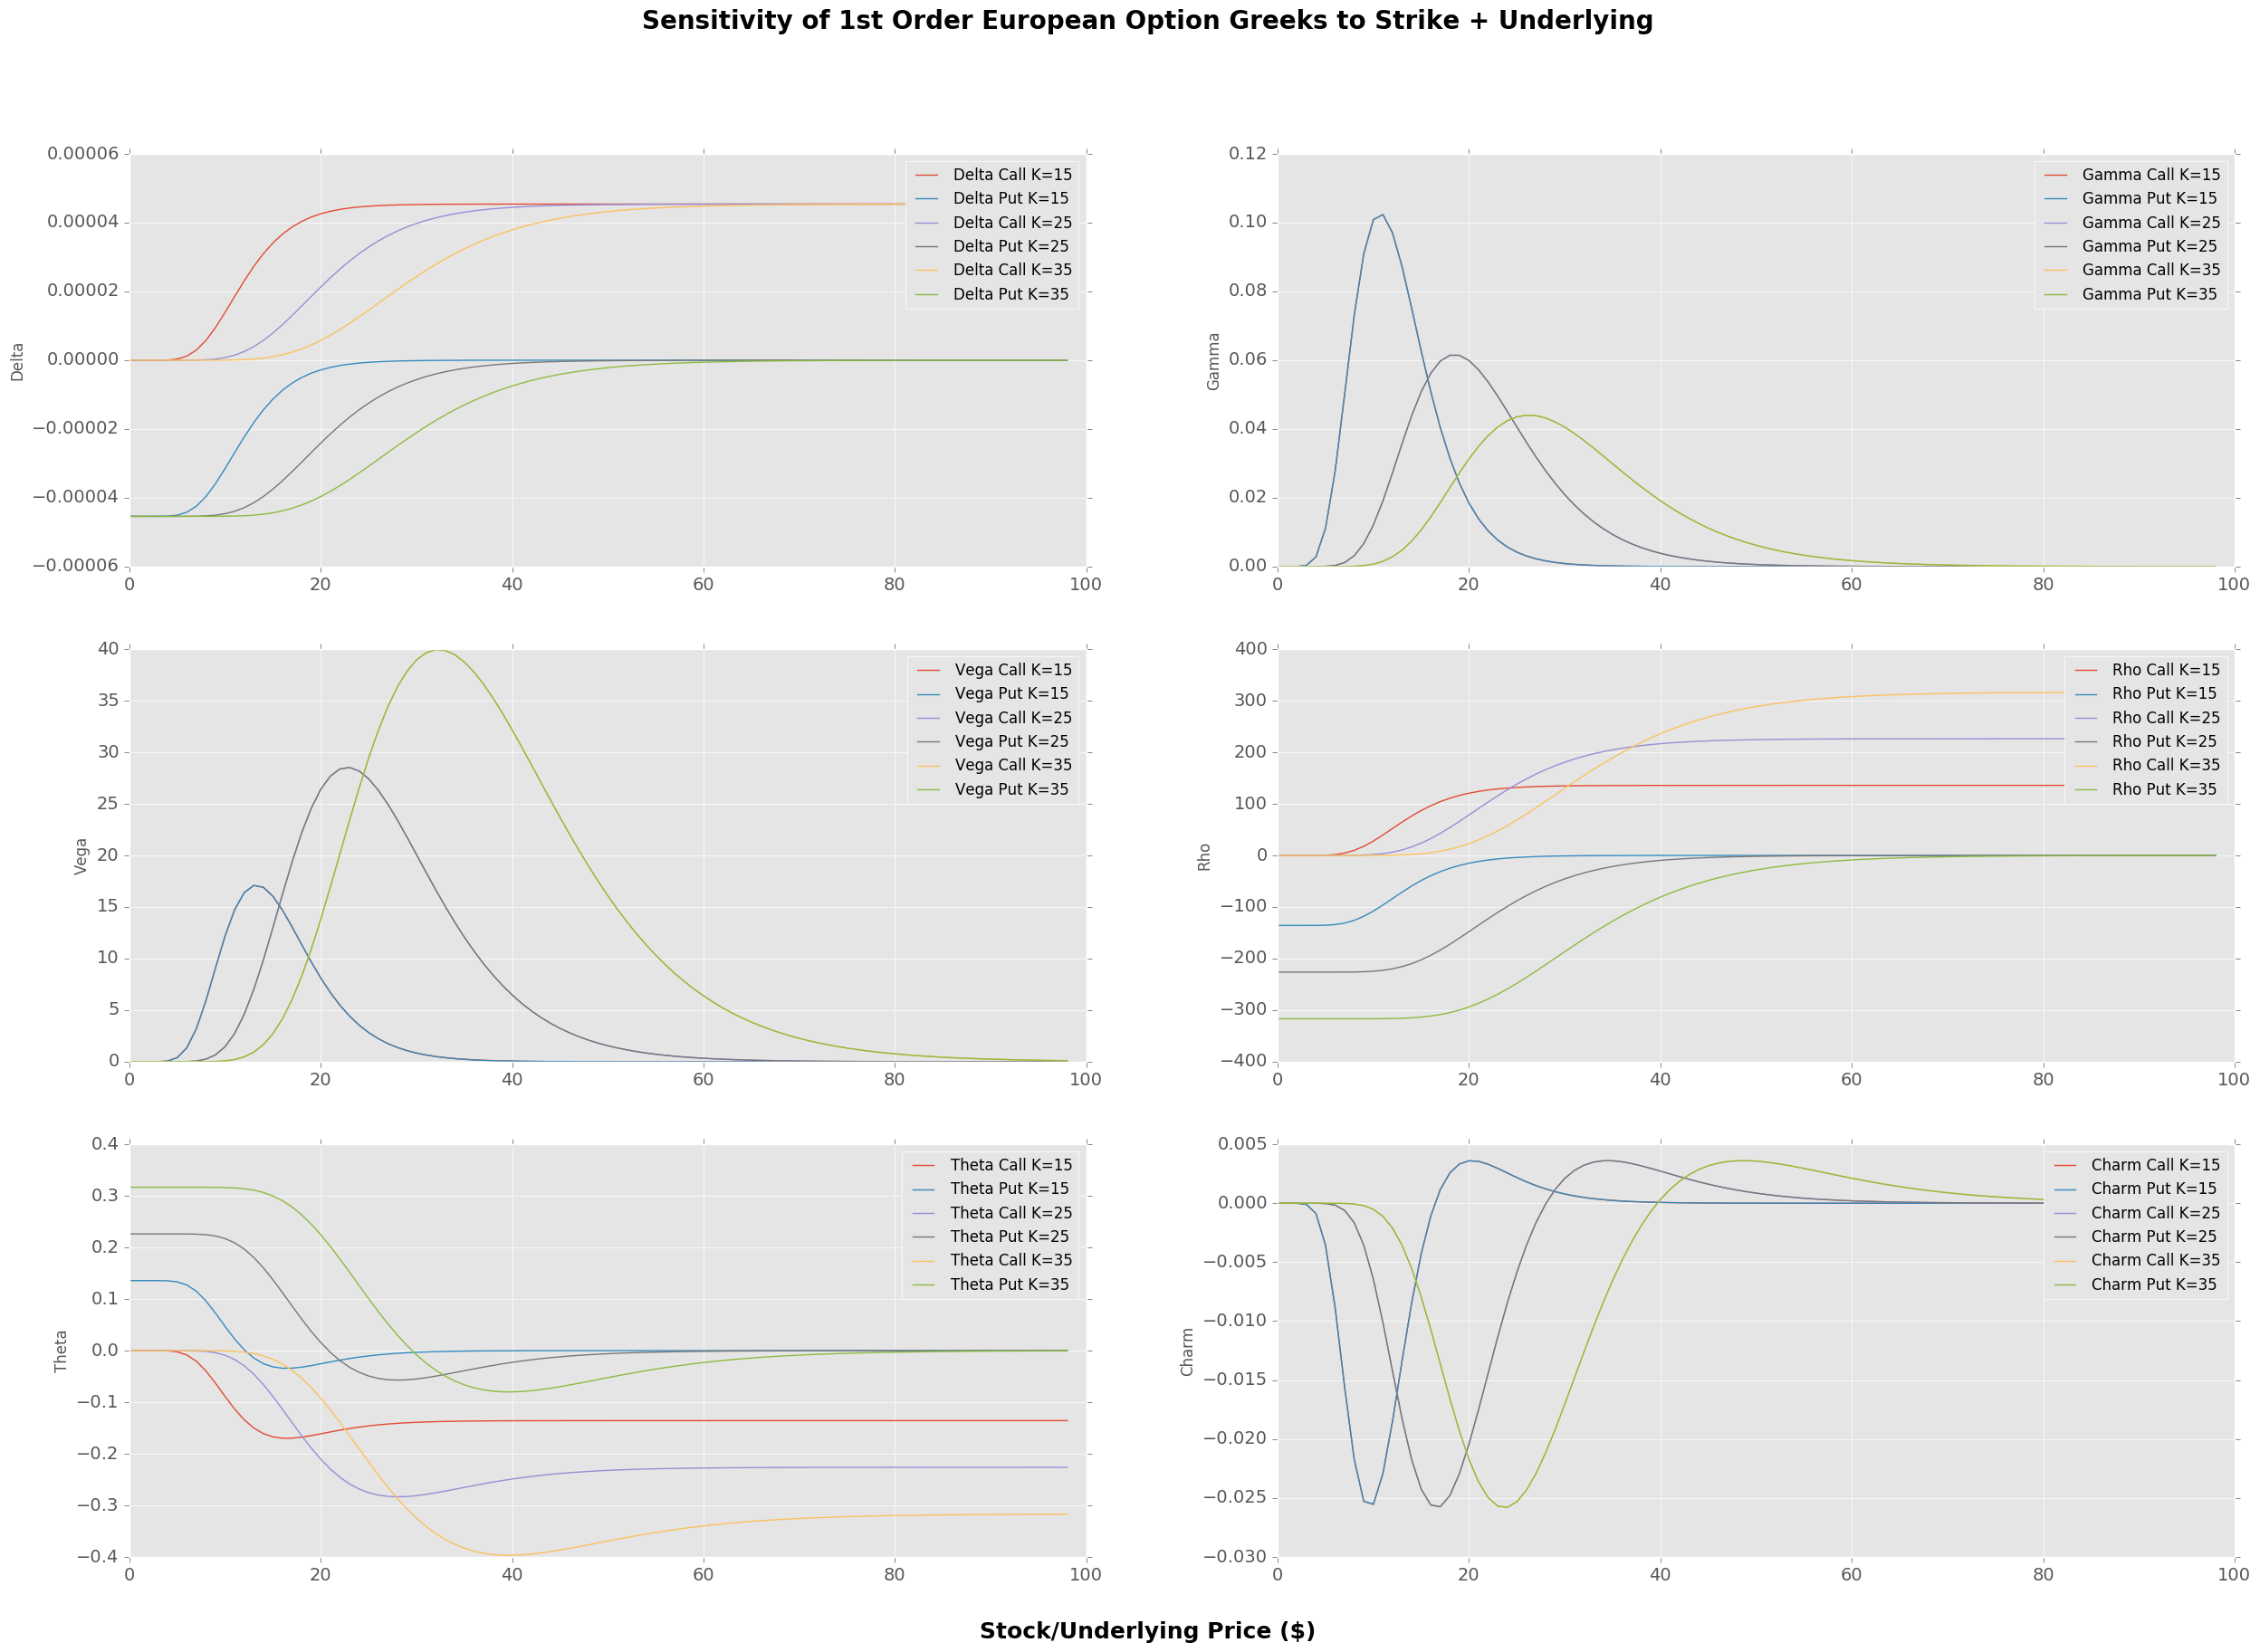

In [158]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(30, 20))
fig.suptitle('Sensitivity of 1st Order European Option Greeks to Strike + Underlying', fontsize=20, fontweight='bold')
fig.text(0.5, 0.08, 'Stock/Underlying Price ($)', ha='center', fontsize=18, fontweight='bold')
vals = [15,25,35]

r = 0.01
vol = 0.1
T = 10
t = 0
plt.subplot(321)
for i in vals:
    tmp_c = [delta(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [delta(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Delta Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Delta Put K=%i" % i ))

plt.ylabel("Delta")
plt.legend()

plt.subplot(322)
for i in vals:
    tmp_c = [gamma(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [gamma(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Gamma Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Gamma Put K=%i" % i ))

plt.ylabel("Gamma")
plt.legend()

plt.subplot(323)
for i in vals:
    tmp_c = [vega(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [vega(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Vega Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Vega Put K=%i" % i ))

plt.ylabel("Vega")
plt.legend()

plt.subplot(324)

for i in vals:
    tmp_c = [rho(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [rho(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Rho Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Rho Put K=%i" % i ))

plt.ylabel("Rho")
plt.legend()

plt.subplot(325)
for i in vals:
    tmp_c = [theta(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [theta(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Theta Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Theta Put K=%i" % i ))

plt.ylabel("Theta")
plt.legend()

plt.subplot(326)
for i in vals:
    tmp_c = [charm(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [charm(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Charm Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Charm Put K=%i" % i ))

plt.ylabel("Charm")
plt.legend()
plt.show()

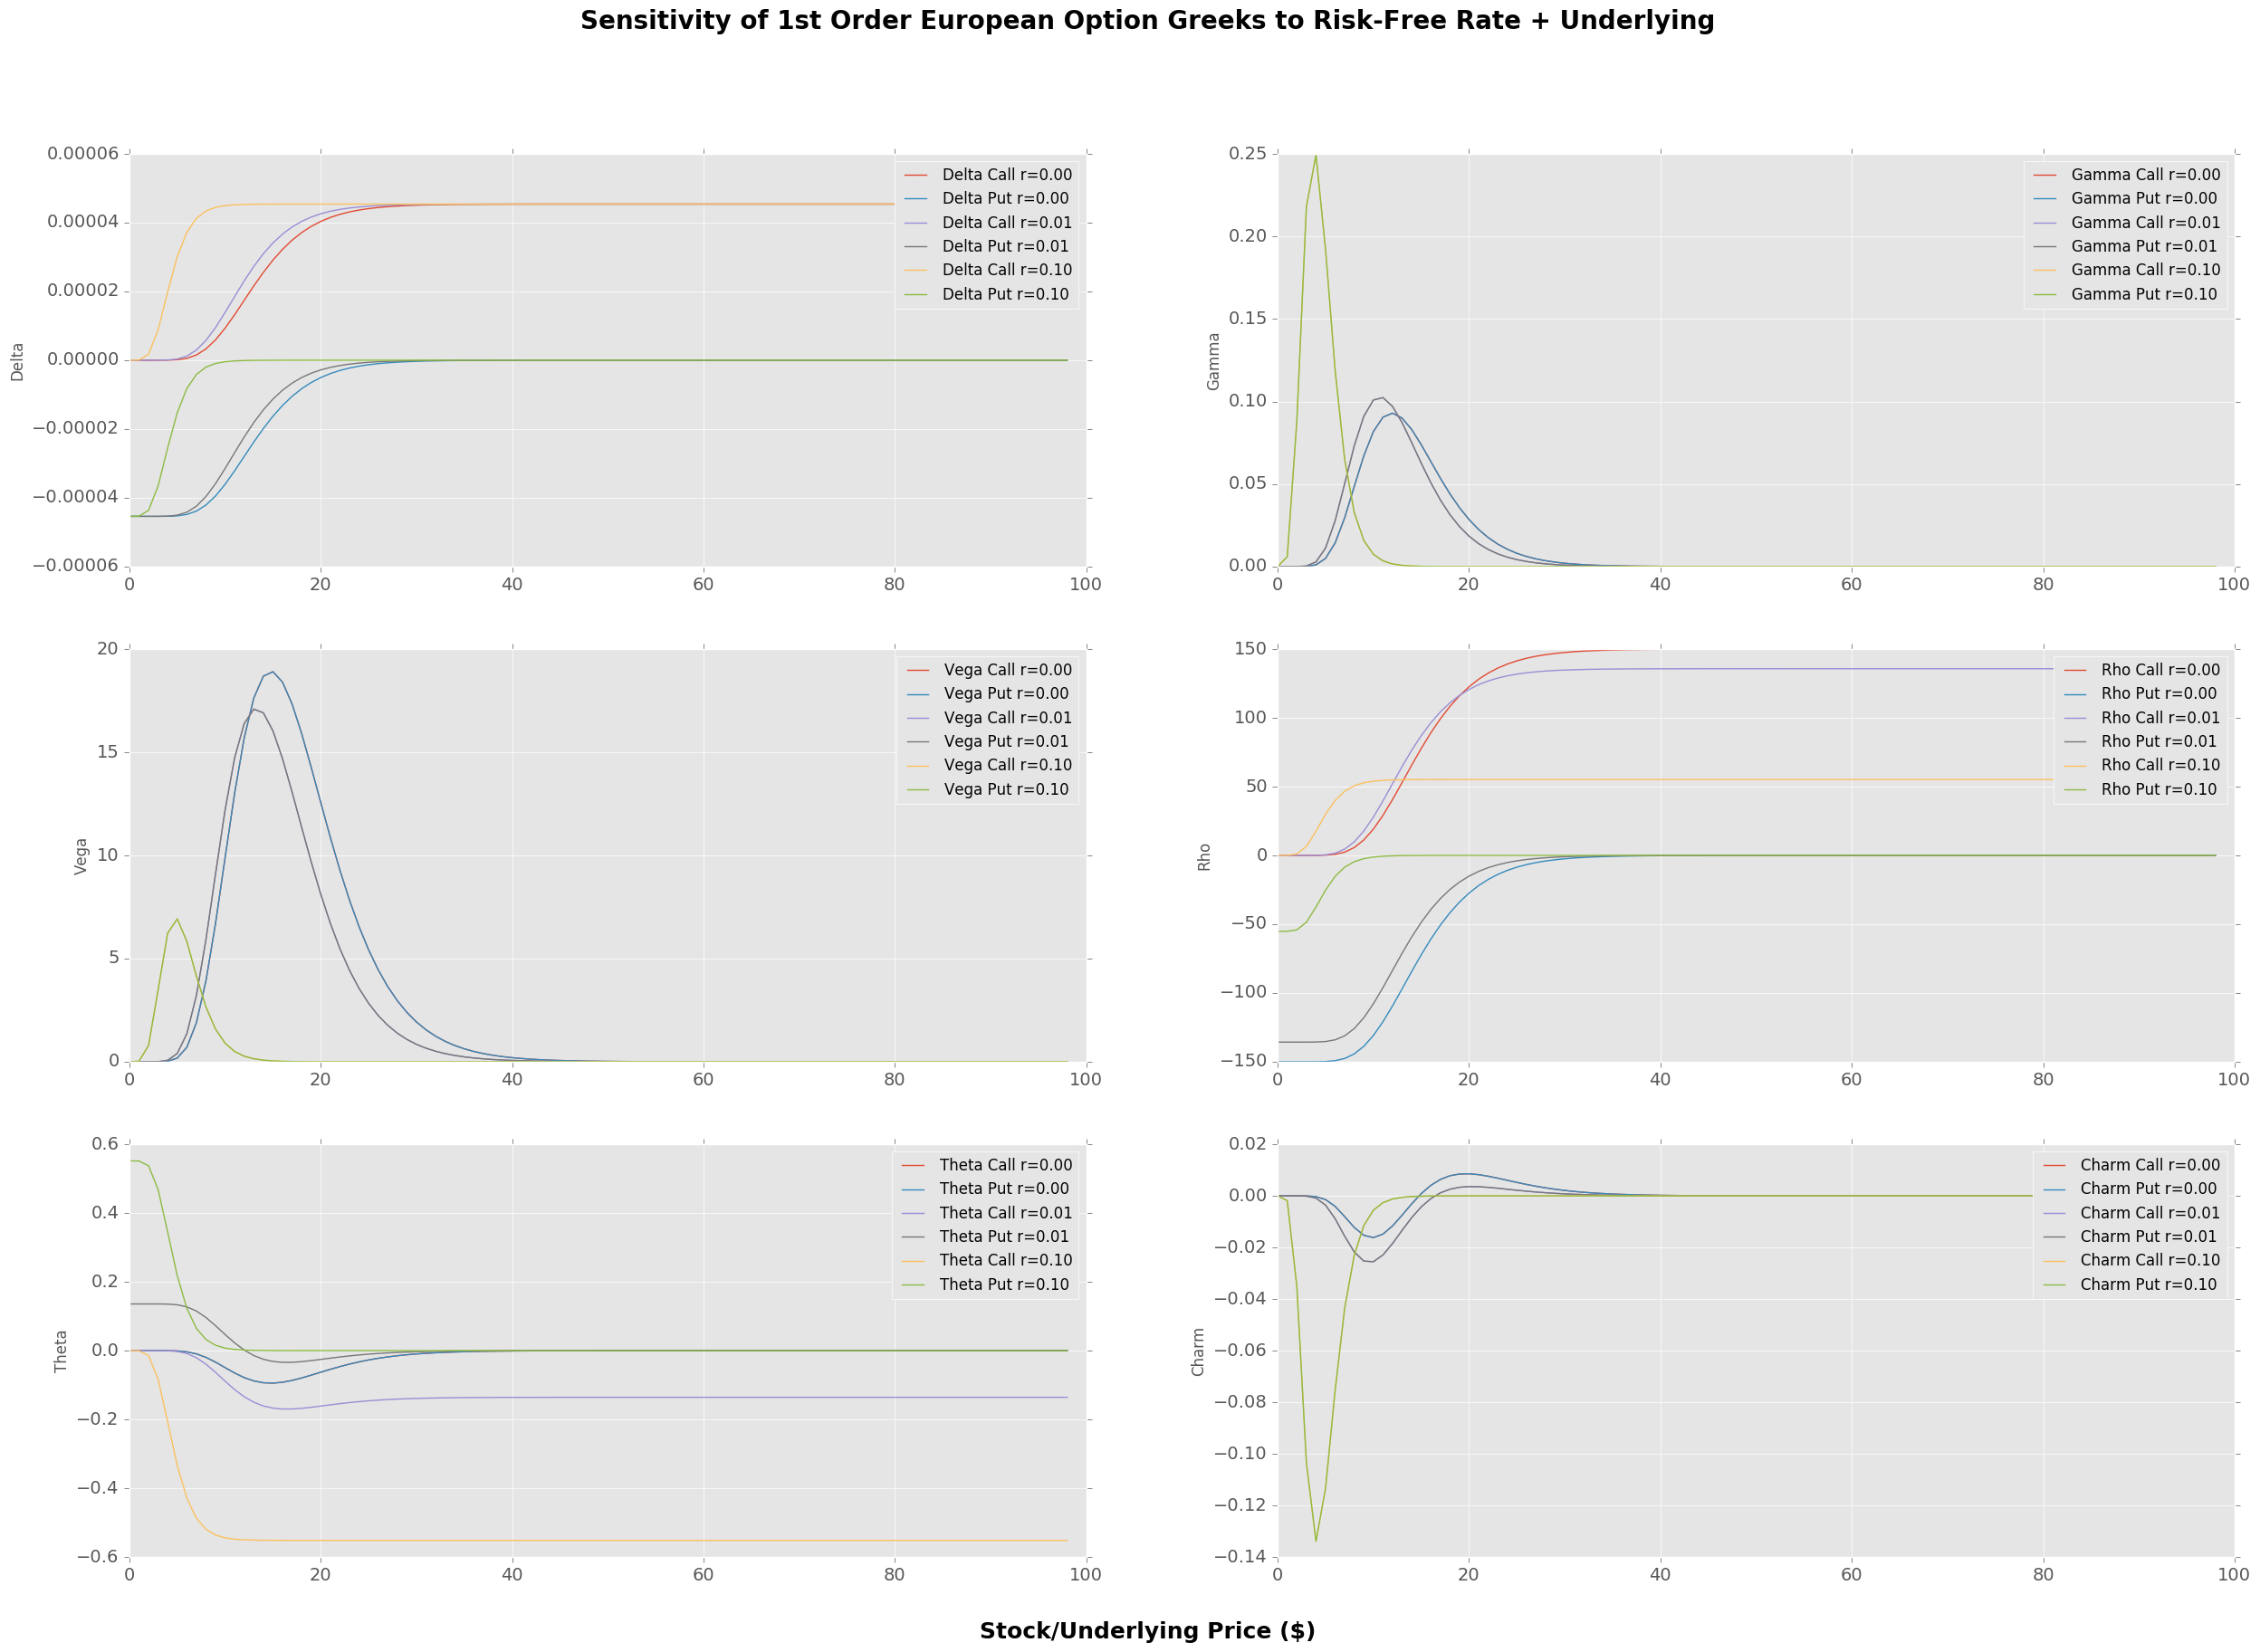

In [159]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(30, 20))
fig.suptitle('Sensitivity of 1st Order European Option Greeks to Risk-Free Rate + Underlying', fontsize=20, fontweight='bold')
fig.text(0.5, 0.08, 'Stock/Underlying Price ($)', ha='center', fontsize=18, fontweight='bold')

vals = [0,0.01,0.1]
K = 15
r = 0.01
vol = 0.1
T = 10
t = 0
plt.subplot(321)
for i in vals:
    tmp_c = [delta(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [delta(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Delta Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Delta Put r=%.2f" % i ))

plt.ylabel("Delta")
plt.legend()

plt.subplot(322)
for i in vals:
    tmp_c = [gamma(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [gamma(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Gamma Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Gamma Put r=%.2f" % i ))

plt.ylabel("Gamma")
plt.legend()

plt.subplot(323)
for i in vals:
    tmp_c = [vega(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [vega(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Vega Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Vega Put r=%.2f" % i ))

plt.ylabel("Vega")
plt.legend()

plt.subplot(324)

for i in vals:
    tmp_c = [rho(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [rho(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Rho Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Rho Put r=%.2f" % i ))

plt.ylabel("Rho")
plt.legend()

plt.subplot(325)
for i in vals:
    tmp_c = [theta(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [theta(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Theta Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Theta Put r=%.2f" % i ))

plt.ylabel("Theta")
plt.legend()

plt.subplot(326)
for i in vals:
    tmp_c = [charm(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [charm(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Charm Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Charm Put r=%.2f" % i ))

plt.ylabel("Charm")
plt.legend()
plt.show()

## Greek Surfaces
The next obvious extension from the above is to look at the dependence of option prices/greeks on two variables at once. This can be done quite easily using matplotlib. 

Some really cool plots from [Smile of Thales](http://www.smileofthales.com/options-greeks-python/) which I've adapted and made a bit more customisable if I want to run for some different greeks. 

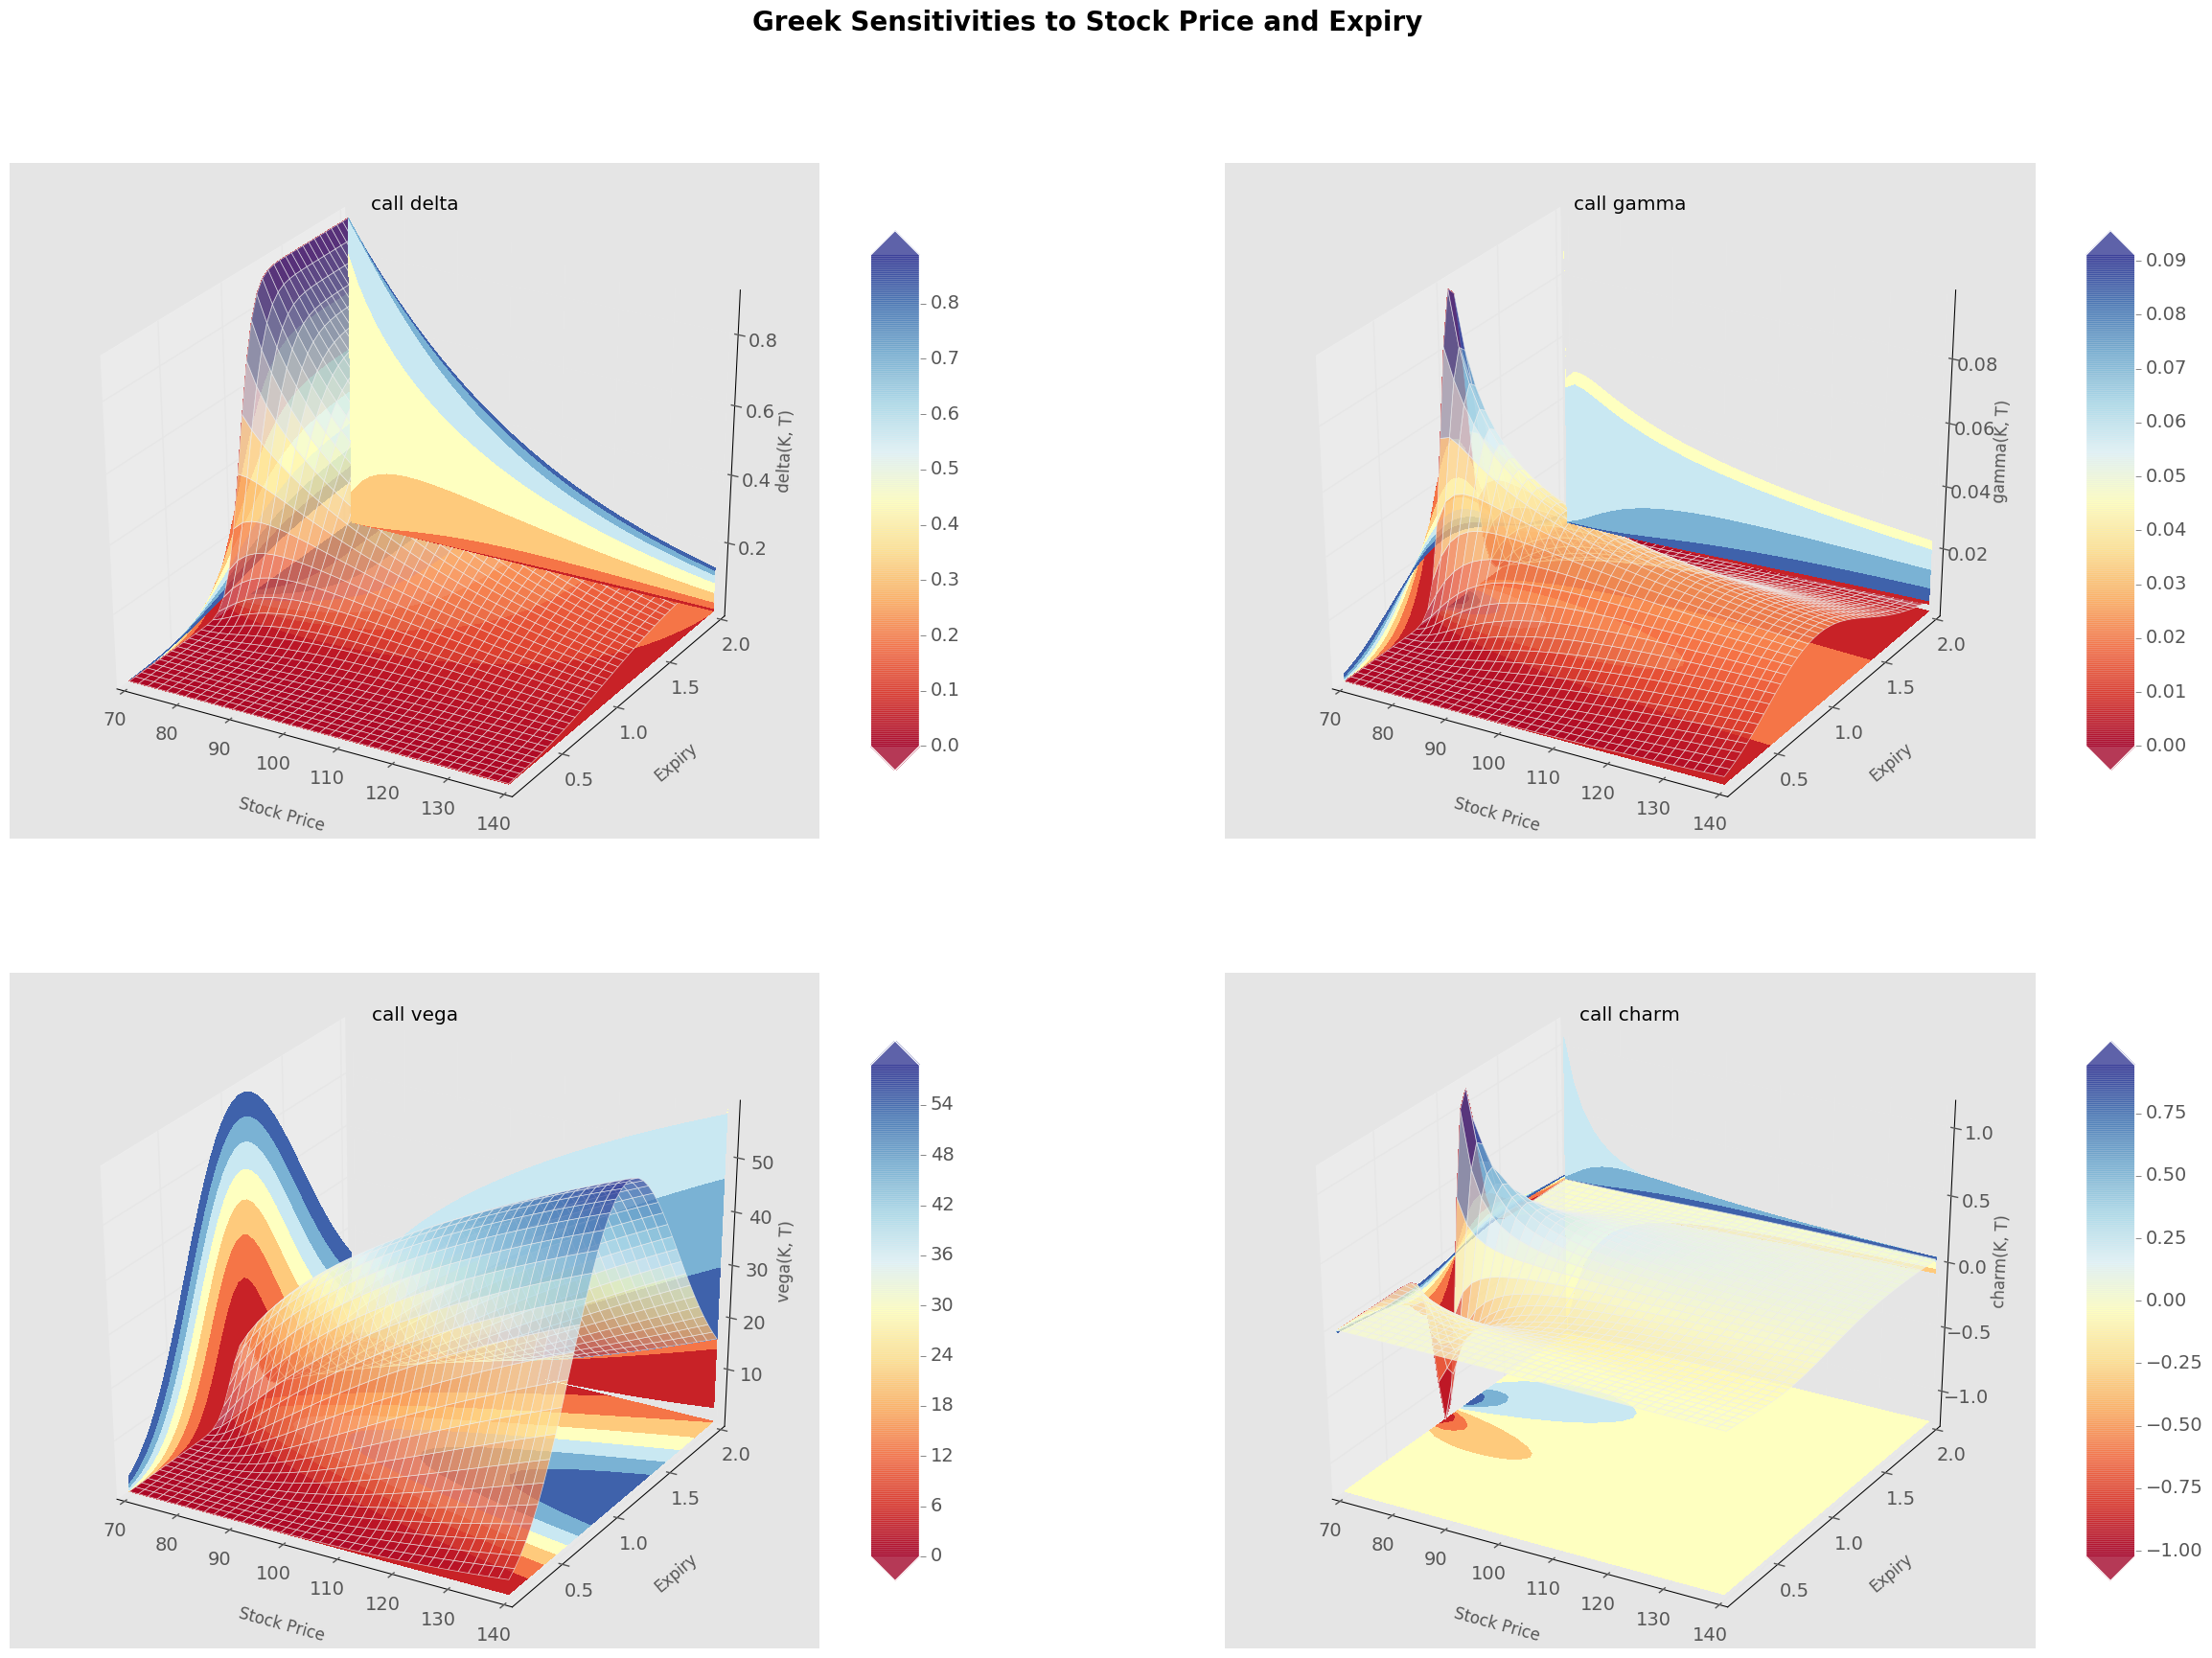

In [268]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


# greek_function: input the function we want to calculate over
# x_var_name: 1st variable we vary
# y_var_name: 2nd variable we vary
# S: vector of underlying prices
# K: vector of strike prices
# r: vector of risk free rates
# vol: vector of volatilities
# T: vector of expiry
# t: vector of current date
# x: meshgrid of 1st variable we vary
# y: meshgrid of 2nd variable we vary
# otype: put/call
# plot: plot figure we want to write to
def greeks_plot_tool(greek_function, x_var_name, y_var_name,
                    S, K, r, vol, T, t, x, y, otype, plot):
   
    # Initialise vector to store our option values and then iterate over
    # Assumption that we're using a constant sized vector length for each variable
    # Need to change the variables being iterated over here for each update (possibly a better way to do this)
    V = np.zeros((len(S), len(S)), dtype=np.float)
    for i in range(len(S)):
        for j in range(len(S)):
            V[i, j] = greek_function(S[i], K[i], r[i], vol[i], T[j], t[i], otype)
 
    # Initiliase plotting canvas

    surf = plot.plot_surface(x, y, V, rstride=1, cstride=1,alpha=0.75,cmap=cm.RdYlBu)
    plot.set_xlabel('\n' + x_var_name, linespacing=4)
    plot.set_ylabel('\n' + y_var_name, linespacing=4)
    plot.set_zlabel("%s(K, T)" % greek_function.__name__)
    plot.set_title("%s %s" % (otype, greek_function.__name__))
    
    # Calculate colour levels based on our meshgrid
    Vlevels = np.linspace(V.min(),V.max(),num=8,endpoint=True)
    xlevels = np.linspace(x.min(),x.max(),num=8,endpoint=True)
    ylevels = np.linspace(y.min(),y.max(),num=8,endpoint=True)
    
    cset = plot.contourf(x, y, V, Vlevels, zdir='z',offset=V.min(),
                       cmap=cm.RdYlBu,linestyles='dashed')
    cset = plot.contourf(x, y, V, xlevels, zdir='x',offset=x.min(),
                       cmap=cm.RdYlBu,linestyles='dashed')
    cset = plot.contourf(x, y, V, ylevels, zdir='y',offset=y.max(),
                       cmap=cm.RdYlBu,linestyles='dashed')

    # Set our viewing constraints
    for c in cset.collections:
        c.set_dashes([(0, (2.0, 2.0))]) # Dash contours

    plt.clabel(cset,fontsize=10, inline=1)
    plot.set_xlim(x.min(),x.max())
    plot.set_ylim(y.min(),y.max())
    plot.set_zlim(V.min(),V.max())

    # Colorbar
    colbar = plt.colorbar(surf, shrink=1.0, extend='both', aspect = 10)
    l,b,w,h = plt.gca().get_position().bounds
    ll,bb,ww,hh = colbar.ax.get_position().bounds
    colbar.ax.set_position([ll, b+0.1*h, ww, h*0.8])
    
        
S = np.linspace(70, 140, 40)
K = np.linspace(105.0, 105.0, 40)
T = np.linspace(0.1, 2.0, 40)
t = np.linspace(0.0, 0.0, 40)
r = np.linspace(0.0, 0.0, 40)
vol = np.linspace(0.12, 0.12, 40)

x, y  = np.meshgrid(S, T)

fig = plt.figure(figsize=(30,20))
fig.suptitle("Greek Sensitivities to Stock Price and Expiry",fontsize=20, fontweight='bold')
greeks = [delta, gamma, vega, charm]

for i in range(len(greeks)):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    greeks_plot_tool(greeks[i],"Stock Price", "Expiry", S, K, r, vol, T, t, x, y, "call", ax)

plt.show()


## References
* https://github.com/yhilpisch/dawp
* http://www.smileofthales.com/options-greeks-python/